# 简介
---------------------
在[上一篇博文](http://www.wyblog.cn/2016/11/05/%e5%a4%a9%e6%b1%a0%e5%88%9d%e4%bd%93%e9%aa%8c%e6%96%b0%e4%ba%ba%e5%ae%9e%e6%88%98%e8%b5%9b%e4%b9%8b%e7%a6%bb%e7%ba%bf%e8%b5%9b/)里，我用spark-sql工具简单的描述了如何操作这个比赛。

但是，存在一个很大的缺陷，就是数据的清晰度不够，我并不能直观的看到数据的分布特征是如何的，在这种状态下去构建特征，完全就是抓瞎，可能构建出的一些比较好的特征也会因为一些区分度不太明显的特征给扰乱，导致预测的不准确。基于以上原因，有必要对数据进行各种维度上的基础统计操作，并且以可视化的方式给展示出来，以便提供给我们是否将其作为特征向量或者如何构造特征向量作为决策依据。

我使用的工具是
- [Pandas](http://pandas.pydata.org/pandas-docs/stable/)
- [Seaborn](http://seaborn.pydata.org/)

用Pandas基于DataFrame去处理数据的确比用SQL方便很多，spark里也接入了DataFrame模型，但是API提供得不够丰富，很多操作存在限制，然而spark在大规模计算上存在无可比拟的优势。Seaborn提供了很多酷炫的数据可视化模型图，要玩转它，还需要不断学习关于统计学的基本知识，我这里学艺还不精，大多数都用的直方图来可视化，比较单一，以后慢慢学习使用其他的。总的来说，在我看来，理想情况下还是用pandas及seaborn进行ETL，然后用spark-mlib进行机器学习模型训练。

阿里移动推荐赛提供的数据仅给出了用户对某个类别里的商品在某个时间点的交互模型，给出的地理位置标签缺失项太多，所以地理位置并不能起多大的作用。基于此，去分析数据大概只能够在时间这一个维度上去花功夫了。另一方面，数据集给出了user_id，item_id，item_category，所以对于特征，可以从这三个方面上基于时间对其分析。根据以下的可视化结果来看，有时候我们自己臆想出的一些特征，其实并没有很好的区分出用户的特点，相反，可能会更加模糊化。

另外，基于时间来分析的时候，有时是统计的一段时间内的行为数总量，有时统计的是某个时间点是否有某个行为，前后两者特征的值在数量级上相差其实比较大，如果贸然的将这两种特征放在一起进行训练，是否能达到理想效果值得商榷。

本篇文章仅记录下我尝试的数据分析的过程，作为新手，过程中难免出现纰漏，希望大家能不吝赐教，大家共同进步。

### 1.首先整理数据

In [1]:
#导入模块
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
rs = np.random.RandomState(10)

#读入user交互数据
user_df=pd.read_csv('train_user.csv')

#定义的函数用于处理时间，将日期与小时分开
def get_date(time):
    date,hour=time.split(" ")
    return date
def get_hour(time):
    date,hour=time.split(" ")
    return hour
user_df['date'] = user_df['time'].map(get_date)
user_df['date'] = pd.to_datetime(user_df['date'])
user_df['hour'] = user_df['time'].map(get_hour)
user_df['hour'] = user_df['hour'].astype(int)
behavior_type_dummies=pd.get_dummies(user_df['behavior_type'])
behavior_type_dummies.columns=['view','favor','addcar','buy']
user_df.drop(['behavior_type','time','user_geohash'],axis=1,inplace=True)
user_df=user_df.join(behavior_type_dummies)
user_df.head()

,user_id,item_id,item_category,date,hour,view,favor,addcar,buy
0,10001082,285259775,4076,2014-12-08,18,1,0,0,0
1,10001082,4368907,5503,2014-12-12,12,1,0,0,0
2,10001082,4368907,5503,2014-12-12,12,1,0,0,0
3,10001082,53616768,9762,2014-12-02,15,1,0,0,0
4,10001082,151466952,5232,2014-12-12,11,1,0,0,0


Pandas的get_dummies()函数是一个非常厉害的函数，它能对clomns进行[独热编码](http://www.wyblog.cn/2016/10/31/%e6%95%b0%e6%8d%ae%e9%a2%84%e5%a4%84%e7%90%86-one-hot%e7%bc%96%e7%a0%81/)。以上我对behavior_type进行独热编码，可以展示出用户对商品在时间点上的具体操作类型，方便以后进行更加详细的统计。

----------------------

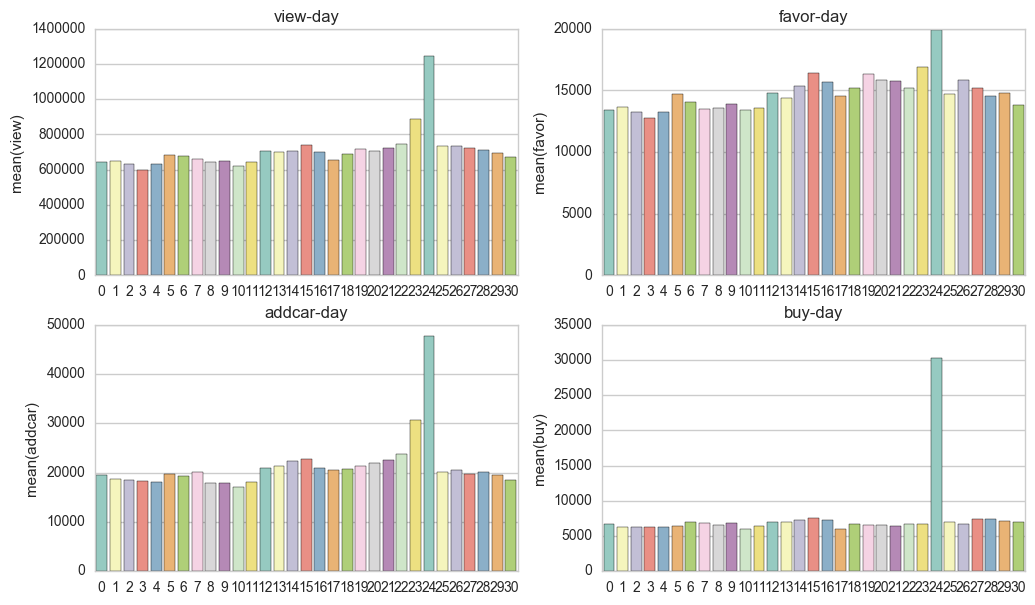

In [2]:
#绘制这个月内每一天所有互动类型的总量
month_total=user_df[['view','favor','addcar','buy','date']].groupby('date',as_index=False).sum()
f,axes=plt.subplots(2,2,figsize=(12,7))
axes[0,0].set_title("view-day")
axes[0,1].set_title("favor-day")
axes[1,0].set_title("addcar-day")
axes[1,1].set_title("buy-day")
sns.barplot(month_total.index, month_total.view,palette="Set3",ax=axes[0,0])
sns.barplot(month_total.index, month_total.favor,palette="Set3",ax=axes[0,1])
sns.barplot(month_total.index, month_total.addcar,palette="Set3",ax=axes[1,0])
sns.barplot(month_total.index, month_total.buy,palette="Set3",ax=axes[1,1])

在以上统计图里，有几个比较有意思的现象。
1. 首先比较明显的看到，在第24天(也就是双十二)，数据有明显的波动。在双十二前一天，浏览、收藏以及加购行为相对于平时，都有一定的提升，但是购买行为，仅仅在双十二当天才有异常，其余日期上都比较稳定。这在如何处理双十二及双十二前后一天的数据上需要仔细考虑。
2. 在这一个月时间内，数据似乎存在一个小周期，一个星期内，各种行为量先下降后上升。